<a href="https://colab.research.google.com/github/MostafaAyman3/BrainTumor/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# تثبيت kaggle لتحميل البيانات
!pip install kaggle

# رفع ملفات kaggle.json الخاصة بك
from google.colab import files
files.upload()

# إنشاء دليل .kaggle ونقل ملف kaggle.json إليه
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# تحميل البيانات من Kaggle
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

# استخراج البيانات
!unzip brain-tumor-classification-mri.zip -d ./brain_tumor_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
100% 86.8M/86.8M [00:06<00:00, 21.1MB/s]
100% 86.8M/86.8M [00:06<00:00, 14.4MB/s]
Archive:  brain-tumor-classification-mri.zip
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(1).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(10).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(100).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(11).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(12).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(13).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(14).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(15).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(16).jpg  
  inflating: ./brain_tumor_dataset/Testing/glioma_tumor/image(17).jpg  
  inflating: 

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# المسار إلى مجلد التدريب
train_data_path = '/content/brain_tumor_dataset/Training'

# الفئات الموجودة في مجموعة البيانات
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# قوائم لتخزين الصور والتسميات
images = []
labels = []

# تحميل الصور والتسميات
for category in categories:
    category_path = os.path.join(train_data_path, category)
    class_label = categories.index(category)  # تعيين رقم لكل فئة

    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
          # Resize images to a consistent size
            image = cv2.resize(image, (128, 128))  # Adjust the size as needed
            images.append(image)
            labels.append(class_label)

# تحويل القوائم إلى numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f'Total images: {len(images)}')


Total images: 2870


In [ ]:
clahe_images = []
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for image in images:
    clahe_image = clahe.apply(image)
    clahe_images.append(clahe_image)


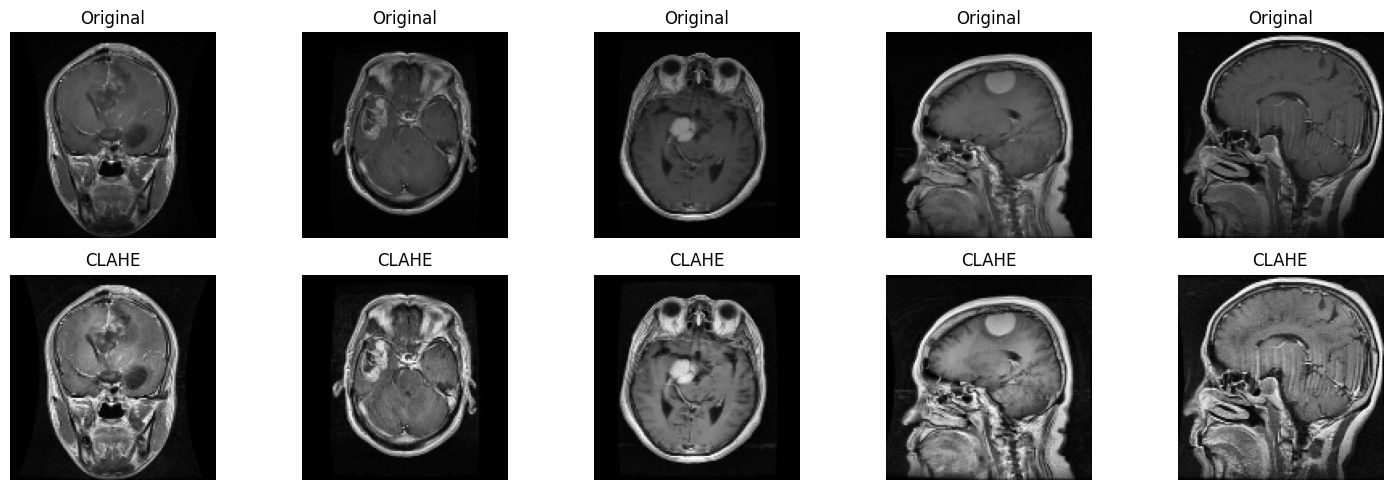

In [ ]:
import matplotlib.pyplot as plt

# اختيار 5 صور عشوائية
indices = np.random.choice(len(images), 5, replace=False)

# عرض الصور قبل وبعد تطبيق CLAHE
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    # الصورة الأصلية
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # الصورة بعد تطبيق CLAHE
    plt.subplot(2, 5, i + 6)
    plt.imshow(clahe_images[idx], cmap='gray')
    plt.title('CLAHE')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from skimage import feature, measure
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# 1. CLAHE Application
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(gray)

# 2. LBP Calculation
def calculate_lbp(image):
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(image, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Contour Detection Algorithm
def contour_detection(image):
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(image)
    if contours:
        cv2.drawContours(contour_img, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
        return contour_img
    else:
        print("No contours found.")
        return None

# 3. Calculate Morphological Features
def calculate_morphological_features(segmented_image):
    regions = measure.regionprops(segmented_image)
    features = []
    for region in regions:
        if region.perimeter == 0:
            continue
        features.append([
            region.area,
            region.centroid[0],
            region.centroid[1],
            region.perimeter,
            (4 * np.pi * region.area) / (region.perimeter ** 2),
            region.eccentricity,
            region.major_axis_length / (region.minor_axis_length + 1e-6),
            region.major_axis_length,
            region.minor_axis_length,
        ])
    return np.array(features).flatten()

# 4. Process Image Function
def process_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Failed to read image: {image_path}")
            return None
        image = cv2.resize(image, (256, 256))
        clahe_image = apply_clahe(image)
        lbp_features = calculate_lbp(clahe_image)

        contour_image = contour_detection(clahe_image)
        if contour_image is None:
            print(f"No valid region in image: {image_path}")
            return None

        morphological_features = calculate_morphological_features(contour_image)
        if len(morphological_features) == 0:
            print(f"No valid region in image: {image_path}")
            return None

        features = np.hstack([lbp_features, morphological_features])

        # Adjusted feature padding
        max_length = 2000  # Updated length
        if features.shape[0] < max_length:
            features = np.pad(features, (0, max_length - features.shape[0]), 'constant')
        elif features.shape[0] > max_length:
            features = features[:max_length]

        label = os.path.basename(os.path.dirname(image_path))
        return features, label
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# 5. Load Dataset and Split into Train and Test Sets
def load_and_split_dataset(dataset_dir, test_size=0.2):
    data = []
    labels = []
    for tumor_type in os.listdir(dataset_dir):
        tumor_dir = os.path.join(dataset_dir, tumor_type)
        if os.path.isdir(tumor_dir):
            image_paths = [os.path.join(tumor_dir, img_name) for img_name in os.listdir(tumor_dir)]
            for image_path in image_paths:
               # print(f"Processing image: {image_path}")
                result = process_image(image_path)
                if result is not None:
                    features, label = result
                    data.append(features)
                    labels.append(label)

    # Split the dataset into training and testing sets
    X, y = np.array(data), np.array(labels)
    return train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

# 6. Load and Split Dataset
dataset_dir = '/content/brain_tumor_dataset/Training'
X_train, X_test, y_train, y_test = load_and_split_dataset(dataset_dir)
# Print the lengths of the datasets
print(f"Number of training samples: {len(X_train)}")
print(f"Number of training labels: {len(y_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of testing labels: {len(y_test)}")

# 7. Encode Labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# 8. Model Training with SVM and Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=70)),
    ('svm', SVC(kernel='rbf',class_weight='balanced'))  # Default parameters for grid search
])

# Define parameter grid
param_grid = {
    'svm__C': [  15,20,30,50],
    'svm__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train_encoded)

# Best parameters and model
print("Best parameters found: ", grid_search.best_params_)

# 9. Model Evaluation
y_pred = grid_search.predict(X_test)
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


Number of training samples: 2296
Number of training labels: 2296
Number of testing samples: 574
Number of testing labels: 574
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found:  {'svm__C': 20, 'svm__gamma': 'scale'}
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.89      0.90       165
meningioma_tumor       0.79      0.85      0.82       165
        no_tumor       0.86      0.84      0.85        79
 pituitary_tumor       0.97      0.94      0.95       165

        accuracy                           0.89       574
       macro avg       0.88      0.88      0.88       574
    weighted avg       0.89      0.89      0.89       574

